In [4]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class ImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        import pandas as pd
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image"]
        image = Image.open(img_path).convert("RGB") # magic trick :)
        if self.transform:
            image = self.transform(image)
        label = self.data.iloc[idx][["label1", "label2"]].values.astype("float32")
        return image, torch.tensor(label)

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = ImageDataset("train.csv", transform=transform)
dataset_val = ImageDataset("test.csv", transform=transform)
train_loader = DataLoader(dataset, shuffle=True)
val_loader = DataLoader(dataset_val, shuffle=False)

In [6]:
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    # check range of the values in x
    if x.min() < 0 or x.max() > 1:
        print("x values are not in the range [0, 1]")
    else:
        print("x values are in the range [0, 1]")

    break

torch.Size([1, 3, 224, 224])
torch.Size([1, 2])
x values are in the range [0, 1]


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(32, 2)  # output 2 values

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return torch.tanh(x)  # Scale outputs to [-1, 1]


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class AdvCNN(nn.Module):
    def __init__(self):
        super(AdvCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(64, 2)  # output 2 values

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return torch.tanh(x)  # Scale outputs to [-1, 1]


In [9]:
class MoreAdvCNN(nn.Module):
    def __init__(self):
        super(MoreAdvCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),   # (3, 224, 224) → (32, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(2),                            # → (32, 112, 112)

            nn.Conv2d(32, 64, 3, stride=1, padding=1),  # → (64, 112, 112)
            nn.ReLU(),
            nn.MaxPool2d(2),                            # → (64, 56, 56)

            nn.Conv2d(64, 128, 3, stride=1, padding=1), # → (128, 56, 56)
            nn.ReLU(),
            nn.MaxPool2d(2),                            # → (128, 28, 28)

            nn.Conv2d(128, 256, 3, stride=1, padding=1),# → (256, 28, 28)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))                # → (256, 1, 1)
        )

        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [10]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [11]:
model = AdvCNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 50


In [12]:
train_loss_arr = []
val_loss_arr = []

best_val_loss = float("inf")
best_model_path = "best_model.pth"
early_stop_patience = 9
epochs_without_improvement = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Evaluation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {avg_train_loss:.4f} — Val Loss: {avg_val_loss:.4f}")
    train_loss_arr.append(avg_train_loss)
    val_loss_arr.append(avg_val_loss)

        # ---- Improvement check ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Validation loss improved. Model saved to {best_model_path}")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        print(f"No improvement. {epochs_without_improvement} epoch(s) without improvement.")

    # ---- Early stopping ----
    if epochs_without_improvement >= early_stop_patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break



Epoch 1/50 — Train Loss: 0.2381 — Val Loss: 0.2169
Validation loss improved. Model saved to best_model.pth
Epoch 2/50 — Train Loss: 0.2355 — Val Loss: 0.2153
Validation loss improved. Model saved to best_model.pth
Epoch 3/50 — Train Loss: 0.2334 — Val Loss: 0.2166
No improvement. 1 epoch(s) without improvement.
Epoch 4/50 — Train Loss: 0.2329 — Val Loss: 0.2126
Validation loss improved. Model saved to best_model.pth
Epoch 5/50 — Train Loss: 0.2313 — Val Loss: 0.2084
Validation loss improved. Model saved to best_model.pth
Epoch 6/50 — Train Loss: 0.2270 — Val Loss: 0.2032
Validation loss improved. Model saved to best_model.pth
Epoch 7/50 — Train Loss: 0.2125 — Val Loss: 0.1770
Validation loss improved. Model saved to best_model.pth
Epoch 8/50 — Train Loss: 0.1834 — Val Loss: 0.1748
Validation loss improved. Model saved to best_model.pth
Epoch 9/50 — Train Loss: 0.1569 — Val Loss: 0.1439
Validation loss improved. Model saved to best_model.pth
Epoch 10/50 — Train Loss: 0.1444 — Val Loss: 

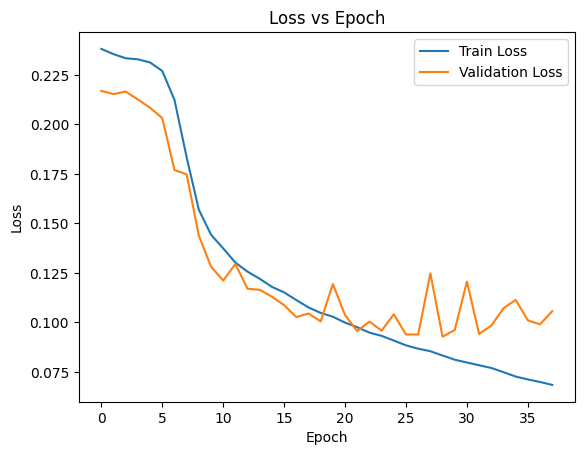

In [13]:
# plot loss
import matplotlib.pyplot as plt

plt.plot(train_loss_arr, label="Train Loss")
plt.plot(val_loss_arr, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

In [14]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 23714


In [15]:
import torch
import torch.onnx

# 1. Load your model architecture
model_2 = AdvCNN()  # Replace with your model class
model_2.load_state_dict(torch.load("best_model.pth", map_location="cpu"))
model_2.eval()  # Set to evaluation mode

# 2. Prepare dummy input (matching input shape of your model)
dummy_input = torch.randn(1, 3, 224, 224)  # Batch size 1, 3 channels, 224x224

# 3. Export to ONNX
torch.onnx.export(
    model_2,                      # Model
    dummy_input,                # Input tensor
    "model_best.onnx",               # Output file
    export_params=True,         # Store weights inside model file
    opset_version=11,           # ONNX version
    do_constant_folding=True,   # Simplify the graph
    input_names=["input"],      # Input node name
    output_names=["output"],    # Output node name
    dynamic_axes={              # Support dynamic batch sizes
        "input": {0: "batch_size"},
        "output": {0: "batch_size"}
    }
)

print("Model exported to ONNX as 'model.onnx'")


Model exported to ONNX as 'model.onnx'
